# Machine Failure Prediction

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [6]:
def check_nulls_dupes(df):
  print(f"The amount of nulls: {df.isna().sum()}")
  print(f"The amount of Dupes: {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/downloads/data.csv")
df

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0
...,...,...,...,...,...,...,...,...,...,...
939,0,7,7,1,6,4,73,6,24,1
940,0,7,5,2,6,6,50,6,24,1
941,0,3,6,2,7,5,43,6,24,1
942,0,6,6,2,5,6,46,7,24,1


# Check For Nulls & Dupes

In [4]:
check_nulls_dupes(df)

The amount of nulls: footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64
The amount of Dupes: 1


In [5]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

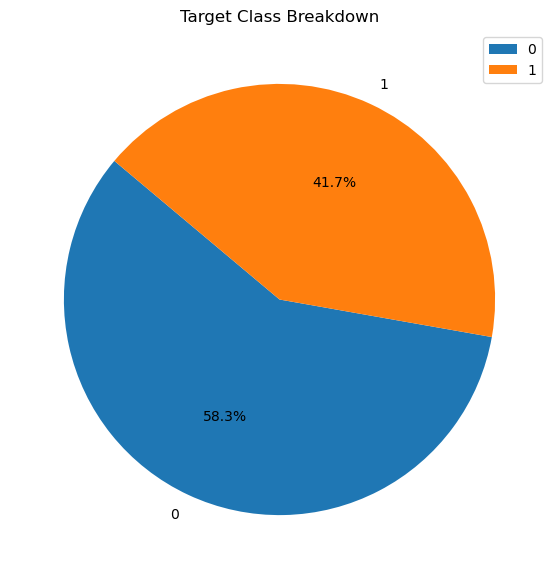

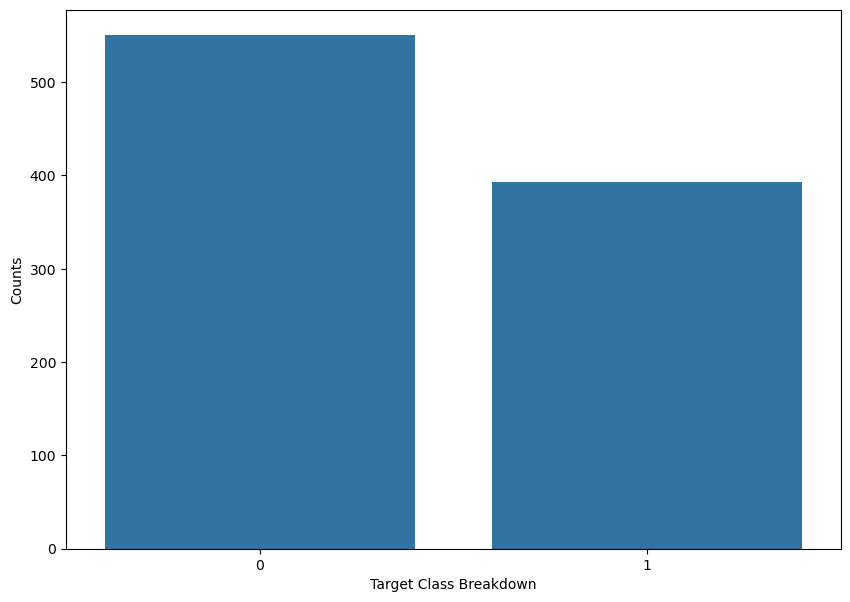

In [7]:
check_class_imbalance(df["fail"])

# Fairly Balanced Dataset